# Algoritmos de Clustering

Son algoritmos de **clasificación no supervisada**, en otras palabras, capaces de inferir a partir de la generación de clusters distintas **clases** en las que pueden **clasificarse** las características entregadas.

#### Importando librerias principales

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()
import ipywidgets as wg
from IPython.display import display
from Auxiliar import funciones

## K-Means

**K-Means** es un algoritmo de **clasificación no supervisada** intuitivo de entender. Busca $K$ centroides de clusters que representen la **media** de las caracterísiticas al rededor de estos. De esta forma, todos los puntos dentro del $cluster_i$, donde $i \in \{1,2,...,K\}$, están mas cerca del $centroide_i$ que de cualquier otro $centroide$.

A continuación mostramos una distribución aleatoria, sin clases conocidas.

In [2]:
from sklearn.datasets.samples_generator import make_blobs
def mostrarDataset(muestras, centros, dist_std):
    X, y = make_blobs(n_samples=muestras, centers=centros, random_state=0, cluster_std=dist_std)
    plt.scatter(X[:, 0], X[:, 1], s=50)

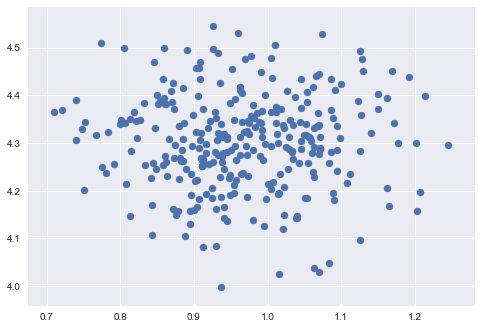

In [3]:
muestras_param = wg.IntSlider(value=300, min=50, max=1000, step=50)
centros_param  = wg.IntSlider(value=1, min=1, max=10, step=1)
dist_std_param = wg.FloatSlider(value=0.1, min=0.1, max=1.0, step=0.1)
wg.interact(mostrarDataset, muestras=muestras_param, centros=centros_param, dist_std=dist_std_param);

A la vista, es realmente fácil seleccionar los clusters requeridos. Sin embargo, si fuesemos a ejecutar una busqueda exaustiva por los clusters el espacio de búsqueda sería exponencial en función al número de puntos. Afortunadamente, existe un procedimiento muy conocido llamado **Expectation Maximization (EM)** el cual está implementado por scikit-learn, así que el algoritmo de **K-Means** puede ser resuelto rapidamente.

In [4]:
 X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=0.60)

In [5]:
from sklearn.cluster import KMeans
def mostrarKMeans(K):
    est = KMeans(K)  # K clusters
    est.fit(X)
    y_kmeans = est.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');

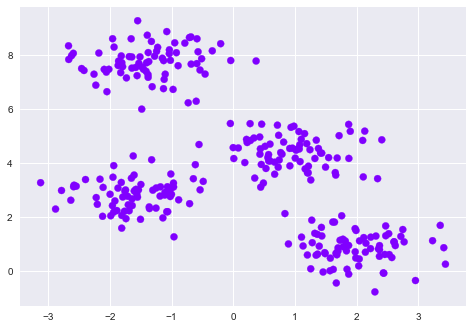

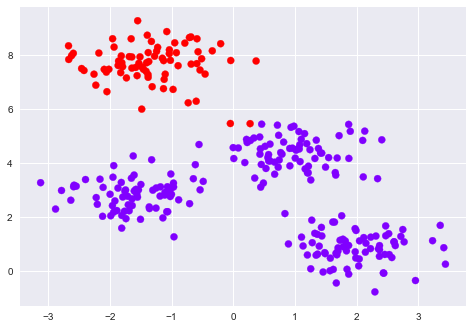

In [6]:
K_param = wg.IntSlider(value=1, min=1, max=10, step=1)
wg.interact(mostrarKMeans, K=K_param);

El algoritmo identifica los cuatro clusters de puntos en una forma muy similar a lo que puede ser apreciado por nuestros ojos y mente.

## El Algoritmo de K-Means: Expectation Maximization

El algormitmo de **K-Means** se vale del enfoque de **Expectation Maximization (maximización de expectativa)** para llegar a una solución.

El enfoque de *Expectation-Maximization* consiste en los siguientes dos pasos:

1. Asignar aleatoriamente centroides de clusters
2. Repetir hasta la convergencia (idempotencia)
 - Asignar cada punto a su centroide mas próximo
 - Asignar cada centroide al centro de los puntos que se relacionaron con él

/Users/junior/anaconda/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


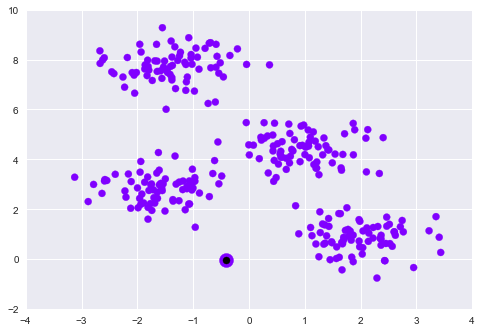

In [8]:
funciones.mostrar_kmeans_interactivo();

This algorithm will (often) converge to the optimal cluster centers.

#### Observación

La convergencia de este algoritmo no está garantizada; por esta razón, scikit-learn por defecto usa un largo número de inicializaciones aleatorias y encuentra el mejor resultado.

Adicionalmente, el número de clusters debe ser configurado manualmente. Existen otros algoritmos de clustering que no requieren la configuración de cluster manual.

## KMeans para compresión de imágenes

Una imágen suele tener miles de colores, pero no en todos los casos es relevante tener tanto detalle. Algunos colores pueden ser considerados como idénticos o muy similares a otros, por lo tanto podríamos procurar tener colores representativos para disminuir la cantidad de colores a mostrar y por ende el peso de nuestras imágenes.

En python disponemos de algunas imágenes para realizar pruebas. Podemos usar una de estas para evaluar si efectivamente la reducción de colores, mostrando menos colores pero mas representativos, puede funcionar adecuadamente.

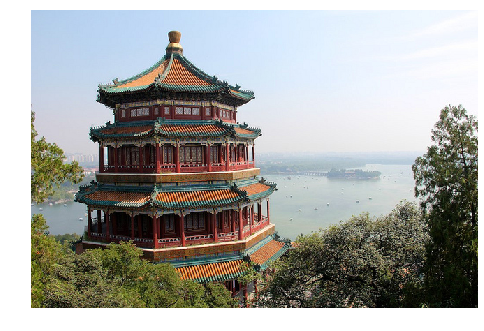

In [9]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
plt.imshow(china)
plt.axis('off')
plt.grid(False);

Esta imagen se encuentra guardada en un array 3-dimensional, de tamaño ``(height, width, RGB)``:

In [10]:
china.shape

(427, 640, 3)

Podemos observar está imagen como un conglomerado de puntos en un espacio de colo 3dimensional. Reescalaremos los valores para que queden entre 0 y 1, luego dispondremos la imagen en un vector para cuplircon la entrada típica de sckikit-learn:

In [11]:
X = (china / 255.0).reshape(-1, 3)
print(X.shape)

(273280, 3)


Ahora tenemos un vector de $273280$ ($427 \times 640$) puntos  $\in \mathbb{R}^3$

<img src='RGB_Cube.png' width="75%">

Ahora nuestra tarea es reducir $256^3$ ($~17M$) colores a un número inferior (e.g.: 64 colores). Basicamente, queremos encontrar $N$ clusters de color en los datos, y crear una imagen nueva donde los verdaderos colores de entrada sean reemplazados por los centroides mas próximos.

In [12]:
def comparandoResultados(n_colores):
    image = china[::2, ::2]

    X = (image / 255.0).reshape(-1, 3)

    clf = KMeans(n_colores)
    labels = clf.fit_predict(X)
    colors = clf.cluster_centers_
    comp_image = colors[labels].reshape(image.shape)
    comp_image = (255 * comp_image).astype(np.uint8)
    
    plt.figure(1, figsize=(20,10))
    plt.suptitle('Comparación')
    plt.subplot(121)
    plt.title('Imagen Normal')
    plt.axis('off')
    plt.imshow(image)
    plt.subplot(122)
    plt.title('Imagen Comprimida')
    plt.axis('off')
    plt.imshow(comp_image)
    plt.show()

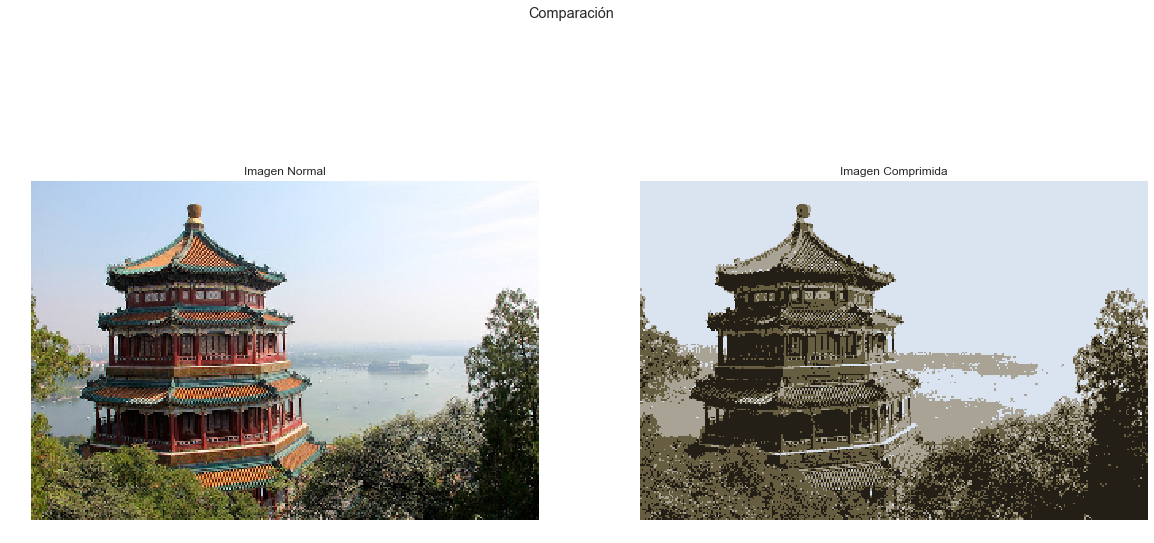

In [13]:
comparandoResultados(4)

Notese la similitud de una imagen de mostrada con casi $17$ millones de colores, a una imagen con solo 64 colores.

## KMeans para clasificación de datos

Ahora usaremos un dataset cuya información a simple vista no nos revela nada. Usaremos **K-Means** para clusterizar automaticamente los datos en un espacio de 64 dimensiones, y luego miraremos a los centros del cluster para ver que infirió el algoritmo.

In [14]:
dataset = funciones.obtenerDatasetDesconocido()
dataset.iloc[:,:]

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0
5,0.0,0.0,12.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,9.0,16.0,16.0,10.0,0.0,0.0
6,0.0,0.0,0.0,12.0,13.0,0.0,0.0,0.0,0.0,0.0,...,8.0,0.0,0.0,0.0,1.0,9.0,15.0,11.0,3.0,0.0
7,0.0,0.0,7.0,8.0,13.0,16.0,15.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,13.0,5.0,0.0,0.0,0.0,0.0
8,0.0,0.0,9.0,14.0,8.0,1.0,0.0,0.0,0.0,0.0,...,8.0,0.0,0.0,0.0,11.0,16.0,15.0,11.0,1.0,0.0
9,0.0,0.0,11.0,12.0,0.0,0.0,0.0,0.0,0.0,2.0,...,4.0,0.0,0.0,0.0,9.0,12.0,13.0,3.0,0.0,0.0


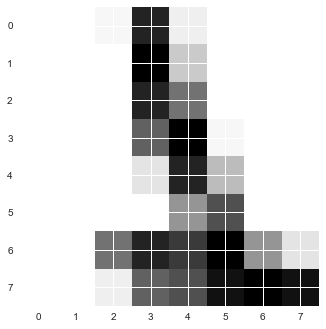

In [15]:
def mostrarDato(n):
    punto=dataset.iloc[n,:]
    plt.imshow(punto.reshape(8,8))
n_param = wg.IntSlider(value=1000, min=0, max=1796, step=1)
wg.interact(mostrarDato, n=n_param);

In [16]:
k=10
clusterizacion = KMeans(n_clusters=k)
clusters = clusterizacion.fit_predict(dataset.iloc[:,:])
clusterizacion.cluster_centers_.shape

(10, 64)

Podemos apreciar la cantidad de clusters especificada, en 64 dimensiones. Visualicemos cada uno de estos clusters para ver lo que representan.

In [17]:
def mostrarClusters(K):
    clusterizacion = KMeans(n_clusters=K)
    clusters = clusterizacion.fit_predict(dataset.iloc[:,:])
    fig = plt.figure(figsize=(30, 10))
    for i in range(K):
        ax = fig.add_subplot(5, 5, 1 + i, xticks=[], yticks=[])
        ax.imshow(clusterizacion.cluster_centers_[i].reshape((8, 8)), cmap=plt.cm.binary)

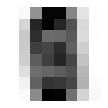

In [18]:
K_param = wg.IntSlider(value=1, min=1, max=25, step=1)
wg.interact(mostrarClusters, K=K_param);

Podemos apreciar que *incluso sin etiquetas de clases*, **K-Means** fue capaz de encontrar clusters cuyas medias son digitos reconocibles.

The cluster labels are permuted; let's fix this:

In [19]:
clusterizacion = KMeans(n_clusters=10)
clusters = clusterizacion.fit_predict(dataset.iloc[:,:])

In [20]:
from scipy.stats import mode
from sklearn.datasets import load_digits
digits = load_digits()

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Para visualizar bien, usemos PCA y miremos la distribución de los datos por clasificación real y por clasificación inferida:

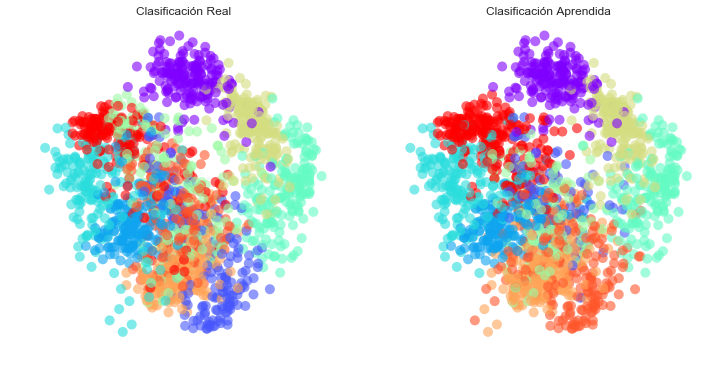

In [21]:
from sklearn.decomposition import PCA

X = PCA(2).fit_transform(digits.data)

kwargs = dict(cmap = plt.cm.get_cmap('rainbow', 10), edgecolor='none', alpha=0.6, s=100)

fig, ax = plt.subplots(1, 2, figsize=(12, 6));

ax[0].set_title('Clasificación Real');
ax[0].axis('off');
ax[0].scatter(X[:, 0], X[:, 1], c=digits.target, **kwargs);

ax[1].set_title('Clasificación Aprendida');
ax[1].axis('off');
ax[1].scatter(X[:, 0], X[:, 1], c=labels, **kwargs);

### Resultados

Y ahora veamos que tan bueno es nuestro **clasificador NO supervisado K-Means**

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7890929326655537

Casi 80%, NADA MAL!

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(digits.target, labels)
print(cm)

[[177   0   0   0   1   0   0   0   0   0]
 [  0  55  24   1   0   1   2   0  99   0]
 [  1   2 148  13   0   0   0   3   8   2]
 [  0   0   0 156   0   2   0   7   7  11]
 [  0   7   0   0 163   0   0   9   2   0]
 [  0   0   0   2   2 129   1   0   0  48]
 [  1   1   0   0   0   0 177   0   2   0]
 [  0   2   0   0   0   1   0 174   2   0]
 [  0   5   3   2   0   4   2   5 100  53]
 [  0  20   0   8   0   5   0   8   0 139]]


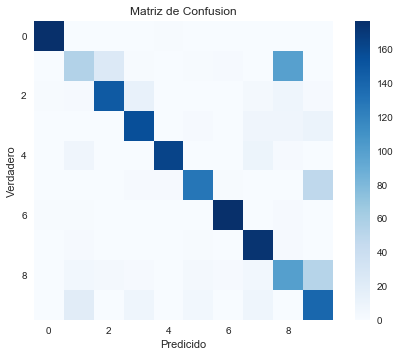

In [24]:
plt.title('Matriz de Confusion')
plt.ylabel('Verdadero')
plt.xlabel('Predicido')
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False);